### Maximum Independent Set

In [1]:
## import necessary libraries
import os
import json 
import glob
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo

In [3]:
def read_graph_from_file(file_path):
    """
    Reads a graph from a text file and returns the number of nodes, edges, and edge list.

    Parameters:
    - file_path: str, path to the text file containing the graph definition.

    Returns:
    - num_nodes: int, number of nodes in the graph.
    - edges: list of tuple, list of edges in the graph.
    """
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'p':
                num_nodes = int(parts[2])
                num_edges = int(parts[3])
            elif parts[0] == 'e':
                u = int(parts[1]) - 1  # Convert to 0-based index
                v = int(parts[2]) - 1  # Convert to 0-based index
                edges.append((u, v))
    return num_nodes, edges

def create_max_independent_set_model(num_nodes, edges):
    """
    Creates a CPLEX model for the Maximum Independent Set (MIS) problem.

    Parameters:
    - num_nodes: int, the number of nodes in the graph.
    - edges: list of tuple, list of edges in the graph.

    Returns:
    - model: CPLEX model.
    - x: list of CPLEX binary variables representing node selection.
    """
    # Create CPLEX model
    model = Model(name="Maximum Independent Set")

    # Decision variables: x[i] = 1 if node i is in the independent set, 0 otherwise
    x = model.binary_var_list(num_nodes, name="x")

    # Objective: Maximize the number of selected nodes
    model.maximize(model.sum(x[i] for i in range(num_nodes)))

    # Constraints: At most one endpoint of each edge can be in the independent set
    for u, v in edges:
        model.add_constraint(x[u] + x[v] <= 1, f"edge_constraint_{u}_{v}")

    return model, x

In [4]:
file_path = "mis_benchmark_instances/1tc.16.txt"

In [5]:
num_nodes, edges = read_graph_from_file(file_path)
model, x = create_max_independent_set_model(num_nodes, edges)

In [6]:
print(model.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Maximum Independent Set

Maximize
 obj: x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9 + x_10 + x_11
      + x_12 + x_13 + x_14 + x_15
Subject To
 _edge_constraint_1_2: x_1 + x_2 <= 1
 _edge_constraint_1_4: x_1 + x_4 <= 1
 _edge_constraint_2_4: x_2 + x_4 <= 1
 _edge_constraint_2_8: x_2 + x_8 <= 1
 _edge_constraint_3_5: x_3 + x_5 <= 1
 _edge_constraint_3_6: x_3 + x_6 <= 1
 _edge_constraint_3_9: x_3 + x_9 <= 1
 _edge_constraint_4_8: x_4 + x_8 <= 1
 _edge_constraint_5_6: x_5 + x_6 <= 1
 _edge_constraint_5_9: x_5 + x_9 <= 1
 _edge_constraint_5_10: x_5 + x_10 <= 1
 _edge_constraint_6_9: x_6 + x_9 <= 1
 _edge_constraint_6_10: x_6 + x_10 <= 1
 _edge_constraint_6_12: x_6 + x_12 <= 1
 _edge_constraint_7_11: x_7 + x_11 <= 1
 _edge_constraint_7_13: x_7 + x_13 <= 1
 _edge_constraint_9_10: x_9 + x_10 <= 1
 _edge_constraint_9_12: x_9 + x_12 <= 1
 _edge_constraint_10_12: x_10 + x_12 <= 1
 _edge_constraint_11_13:

### Classical Solution

In [7]:
solution = model.solve()

if solution:
    print("Objective value (size of independent set):", solution.objective_value)
    independent_set = [i + 1 for i in range(num_nodes) if x[i].solution_value > 0.5]  # Convert back to 1-based index
    print("Nodes in the maximum independent set:", independent_set)
else:
    print("No solution found.")

optimal_value = solution.objective_value if solution else None

Objective value (size of independent set): 8.0
Nodes in the maximum independent set: [1, 2, 4, 8, 9, 13, 15, 16]


### Making QUBO

In [8]:
qp = from_docplex_mp(model)
converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)

# number of variables
num_vars = qubo.get_num_vars()
print('Number of variables:', num_vars)

Number of variables: 16


In [9]:
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Maximum Independent Set

Minimize
 obj: - x_0 - x_1 - x_2 - x_3 - x_4 - x_5 - x_6 - x_7 - x_8 - x_9 - x_10 - x_11
      - x_12 - x_13 - x_14 - x_15 + [ 34 x_1*x_2 + 34 x_1*x_4 + 34 x_2*x_4
      + 34 x_2*x_8 + 34 x_3*x_5 + 34 x_3*x_6 + 34 x_3*x_9 + 34 x_4*x_8
      + 34 x_5*x_6 + 34 x_5*x_9 + 34 x_5*x_10 + 34 x_6*x_9 + 34 x_6*x_10
      + 34 x_6*x_12 + 34 x_7*x_11 + 34 x_7*x_13 + 34 x_9*x_10 + 34 x_9*x_12
      + 34 x_10*x_12 + 34 x_11*x_13 + 34 x_11*x_14 + 34 x_13*x_14 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1
 0 <= x_6 <= 1
 0 <= x_7 <= 1
 0 <= x_8 <= 1
 0 <= x_9 <= 1
 0 <= x_10 <= 1
 0 <= x_11 <= 1
 0 <= x_12 <= 1
 0 <= x_13 <= 1
 0 <= x_14 <= 1
 0 <= x_15 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9 x_10 x_11 x_12 x_13 x_14 x_15
End



### Solving using QUBO Loss for PCE

In [10]:
from pce import *
from qubo_to_maxcut import *

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.primitives import BackendEstimator
from qiskit_aer import AerSimulator
backend = AerSimulator(method='automatic')

estimator = BackendEstimator(backend=backend, options={'shots': 1000})

In [13]:
pauli_encoder = PauliCorrelationEncoding()

#edges,weights = pauli_encoder.get_edges_from_qp(problem)
k = 2    # type of compression (quadratic or cubic)
num_qubits = pauli_encoder.find_n(qubo.get_num_binary_vars(),k)


pauli_strings = SparsePauliOp(pauli_encoder.generate_pauli_strings(num_qubits,qubo.get_num_binary_vars(), k))


print(f"We can encode the problem with {num_qubits} qubits using {len(pauli_strings)} Pauli strings using k={k} compression,\n which are {pauli_strings}")



We can encode the problem with 4 qubits using 16 Pauli strings using k=2 compression,
 which are SparsePauliOp(['XXII', 'XIXI', 'XIIX', 'IXXI', 'IXIX', 'IIXX', 'YYII', 'YIYI', 'YIIY', 'IYYI', 'IYIY', 'IIYY', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


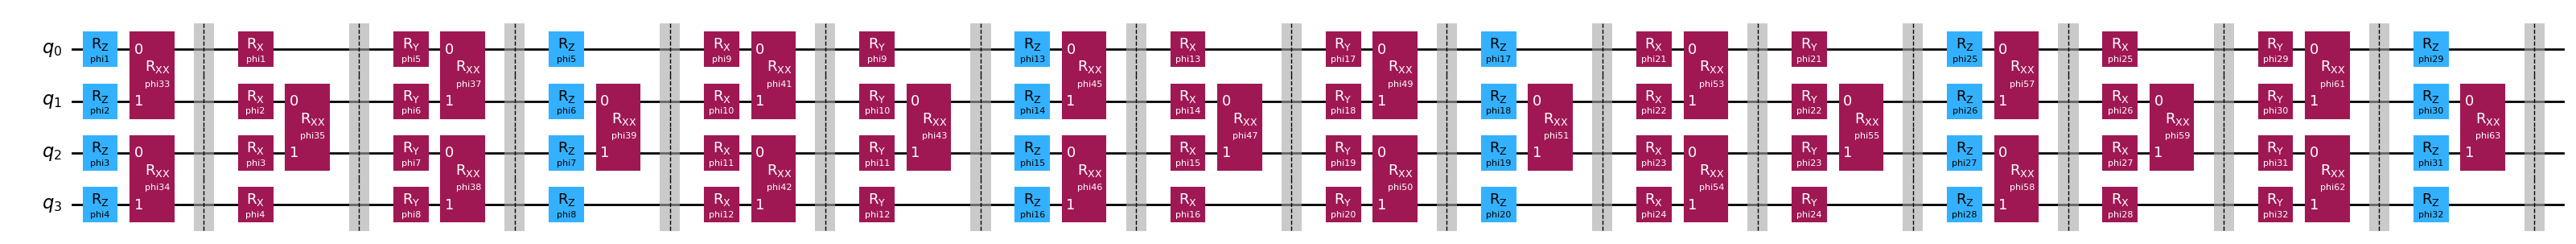

In [14]:
depth = 2 * num_qubits
ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits)
ansatz.draw('mpl',fold=-1)

In [15]:
pce = PauliCorrelationOptimizer(estimator=estimator, 
                                pauli_encoder=pauli_encoder,
                                depth=depth,
                                num_qubits=num_qubits,
                                k=k,
                                method='exact', 
                                loss_method='qubo',
                                qubo=qubo,
                                multi_op=True)  # method can be 'exact' or 'quantum' and loss can 
                                                # be qubo or maxcut



In [16]:
maxiter = 50
from qiskit_algorithms.optimizers import COBYLA,SLSQP,POWELL
optimizer = SLSQP(maxiter=maxiter)
params = np.random.rand(ansatz.num_parameters)
result=pce.optimize(optimizer,params)


Multi Reoptimization

--- Optimization Round 1 ---
Best QUBO cost: inf
QUBO cost: 42.0
Improvement: inf
Improvement detected! Best QUBO cost updated: 42.0
Consecutive no-improvement rounds: 0. Rounds remaining before stopping: 10.

--- Optimization Round 2 ---
Best QUBO cost: 42.0
QUBO cost: 58.0
Improvement: -16.0
No improvement in round 2.
Focusing locally with stronger perturbation.
Consecutive no-improvement rounds: 1. Rounds remaining before stopping: 9.

--- Optimization Round 3 ---
Performing stronger exploration.
Best QUBO cost: 42.0
QUBO cost: 42.0
Improvement: 0.0
No improvement in round 3.
Exploring broader solution space using weighted blending.
Consecutive no-improvement rounds: 2. Rounds remaining before stopping: 8.

--- Optimization Round 4 ---
Best QUBO cost: 42.0
QUBO cost: 41.0
Improvement: 1.0
Improvement detected! Best QUBO cost updated: 41.0
Consecutive no-improvement rounds: 0. Rounds remaining before stopping: 10.

--- Optimization Round 5 ---
Best QUBO cost: 41

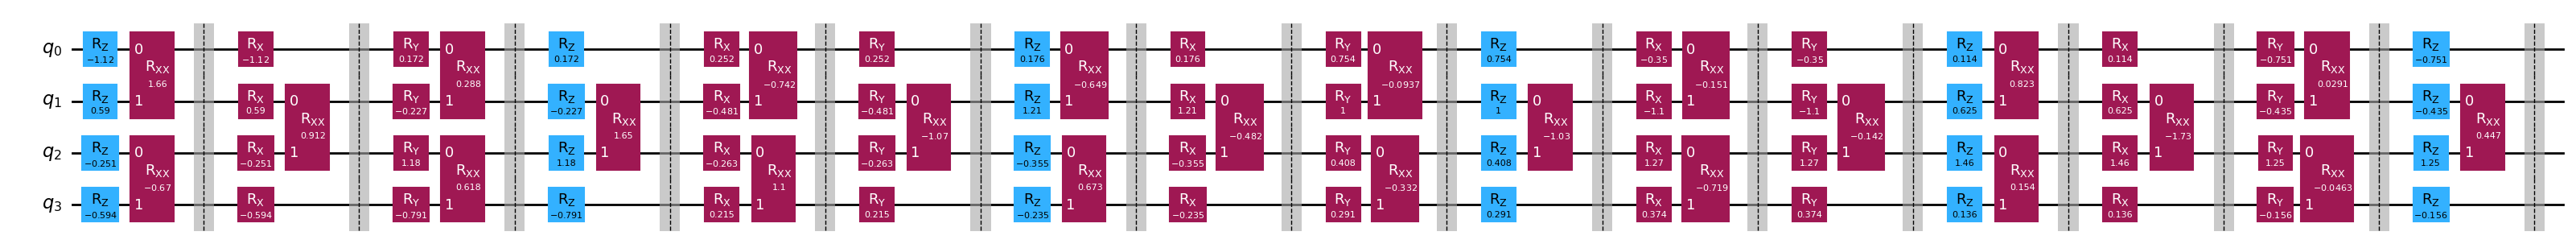

In [17]:
final_ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits).assign_parameters(result)
final_ansatz.draw('mpl',fold=-1)

In [18]:
psi_final = Statevector(final_ansatz)

In [19]:
# Example usage:
# Assuming you have instantiated `psi_final`, `pauli_strings`, and `weight_matrix`
qubo_utility = QUBOUtility()
qubo_bitstring = qubo_utility.evaluate_sign_function(psi_final, pauli_strings)
qubo_cost = qubo.objective.evaluate(qubo_bitstring)

print(qubo_bitstring)
print(qubo_cost)

[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]
25.0


In [20]:
result_initial = converter.interpret(qubo_bitstring)
initial_cost = qp.objective.evaluate(result_initial)
# check feasibility
inital_feasible = qp.get_feasibility_info(result_initial)[0]

print("Initial MIS score             :", initial_cost )
print("Initial MIS solution          :", result_initial)
print("Initial MIS solution feasible :", inital_feasible)

Initial MIS score             : 9.0
Initial MIS solution          : [1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1.]
Initial MIS solution feasible : False


In [21]:
optimized_bitstring, final_cost = qubo_utility.bit_swap_search(qubo, bitstring=qubo_bitstring)
print("Optimized bitstring:", optimized_bitstring)
print("Final cost:", final_cost)

Starting cost: 25.0
Bit flip: Improved solution by flipping bit 5: Cost = 9.0
Bit flip: Improved solution by flipping bit 9: Cost = -7.0
Multi-bit flip: Improved solution by flipping bits (3, 10, 12): Cost = -8.0
Final best cost: -8.0
Optimized bitstring: [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1]
Final cost: -8.0


In [22]:

result_initial = converter.interpret(optimized_bitstring)
initial_cost = qp.objective.evaluate(result_initial)
# check feasibility
inital_feasible = qp.get_feasibility_info(result_initial)[0]

print("Initial Knapsack score             :", initial_cost )
print("Initial Knapsack solution          :", result_initial)
print("Initial Knapsack solution feasible :", inital_feasible)

Initial Knapsack score             : 8.0
Initial Knapsack solution          : [1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1.]
Initial Knapsack solution feasible : True


Now, let's see it via converting it to a weighted max cut

In [23]:
from qiskit_optimization.applications import Knapsack, Maxcut
# the graph
import networkx as nx
import matplotlib.pyplot as plt
def create_graph_from_weight_matrix(w):
    G = nx.Graph()
    n = len(w)

    # Add nodes
    for i in range(n):
        G.add_node(i)

    # Add edges with weights, ignoring zero-weight edges
    for i in range(n):
        for j in range(i + 1, n):
            if w[i, j] != 0:
                G.add_edge(i, j, weight=w[i, j])

    return G

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [24]:
linear = qubo.objective.linear.to_array()
quadratic = qubo.objective.quadratic.to_array()

In [25]:
weight_max_cut_qubo = QUBO(quadratic, linear)
weight_max_cut_qubo.linear_to_square()
max_cut_graph = weight_max_cut_qubo.to_maxcut()
print(max_cut_graph)

[[ 0. -2. 32. 49. 49. 49. 66. 83. 32. 32. 83. 66. 49. 49. 49. 32. -2.]
 [-2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [32.  0.  0. 17.  0. 17.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [49.  0. 17.  0.  0. 17.  0.  0.  0. 17.  0.  0.  0.  0.  0.  0.  0.]
 [49.  0.  0.  0.  0.  0. 17. 17.  0.  0. 17.  0.  0.  0.  0.  0.  0.]
 [49.  0. 17. 17.  0.  0.  0.  0.  0. 17.  0.  0.  0.  0.  0.  0.  0.]
 [66.  0.  0.  0. 17.  0.  0. 17.  0.  0. 17. 17.  0.  0.  0.  0.  0.]
 [83.  0.  0.  0. 17.  0. 17.  0.  0.  0. 17. 17.  0. 17.  0.  0.  0.]
 [32.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 17.  0. 17.  0.  0.]
 [32.  0.  0. 17.  0. 17.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [83.  0.  0.  0. 17.  0. 17. 17.  0.  0.  0. 17.  0. 17.  0.  0.  0.]
 [66.  0.  0.  0.  0.  0. 17. 17.  0.  0. 17.  0.  0. 17.  0.  0.  0.]
 [49.  0.  0.  0.  0.  0.  0.  0. 17.  0.  0.  0.  0.  0. 17. 17.  0.]
 [49.  0.  0.  0.  0.  0.  0. 17.  0.  0. 17. 17.  0.  0.  0.  0.  0.]
 [49. 

In [26]:
max_cut = Maxcut(max_cut_graph)
problem_max_cut = max_cut.to_quadratic_program()
print(problem_max_cut.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 716 x_0 - 2 x_1 + 66 x_2 + 100 x_3 + 100 x_4 + 100 x_5 + 134 x_6 + 168 x_7
      + 66 x_8 + 66 x_9 + 168 x_10 + 134 x_11 + 100 x_12 + 100 x_13 + 100 x_14
      + 66 x_15 - 2 x_16 + [ 8 x_0*x_1 - 128 x_0*x_2 - 196 x_0*x_3 - 196 x_0*x_4
      - 196 x_0*x_5 - 264 x_0*x_6 - 332 x_0*x_7 - 128 x_0*x_8 - 128 x_0*x_9
      - 332 x_0*x_10 - 264 x_0*x_11 - 196 x_0*x_12 - 196 x_0*x_13 - 196 x_0*x_14
      - 128 x_0*x_15 + 8 x_0*x_16 - 68 x_2*x_3 - 68 x_2*x_5 - 68 x_3*x_5
      - 68 x_3*x_9 - 68 x_4*x_6 - 68 x_4*x_7 - 68 x_4*x_10 - 68 x_5*x_9
      - 68 x_6*x_7 - 68 x_6*x_10 - 68 x_6*x_11 - 68 x_7*x_10 - 68 x_7*x_11
      - 68 x_7*x_13 - 68 x_8*x_12 - 68 x_8*x_14 - 68 x_10*x_11 - 68 x_10*x_13
      - 68 x_11*x_13 - 68 x_12*x_14 - 68 x_12*x_15 - 68 x_14*x_15 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1
 0 <= x_6 <= 1
 0 <= x_7 <= 

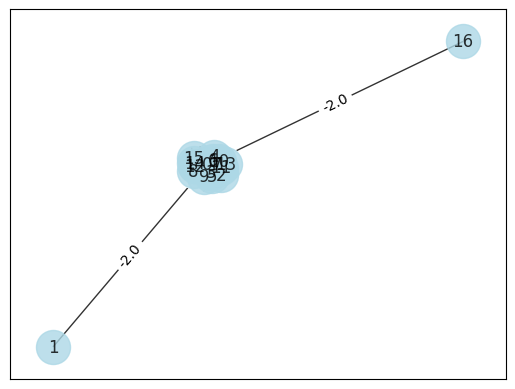

In [27]:
graph = create_graph_from_weight_matrix(max_cut_graph)
draw_graph(graph, "lightblue", nx.spring_layout(graph))

In [28]:
pauli_encoder = PauliCorrelationEncoding()

#edges,weights = pauli_encoder.get_edges_from_qp(problem)
k = 2    # type of compression (quadratic or cubic)
num_qubits = pauli_encoder.find_n(problem_max_cut.get_num_binary_vars(),k)


pauli_strings = SparsePauliOp(pauli_encoder.generate_pauli_strings(num_qubits,problem_max_cut.get_num_binary_vars(), k))


print(f"We can encode the problem with {num_qubits} qubits using {len(pauli_strings)} Pauli strings using k={k} compression,\n which are {pauli_strings}")



We can encode the problem with 4 qubits using 17 Pauli strings using k=2 compression,
 which are SparsePauliOp(['XXII', 'XIXI', 'XIIX', 'IXXI', 'IXIX', 'IIXX', 'YYII', 'YIYI', 'YIIY', 'IYYI', 'IYIY', 'IIYY', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


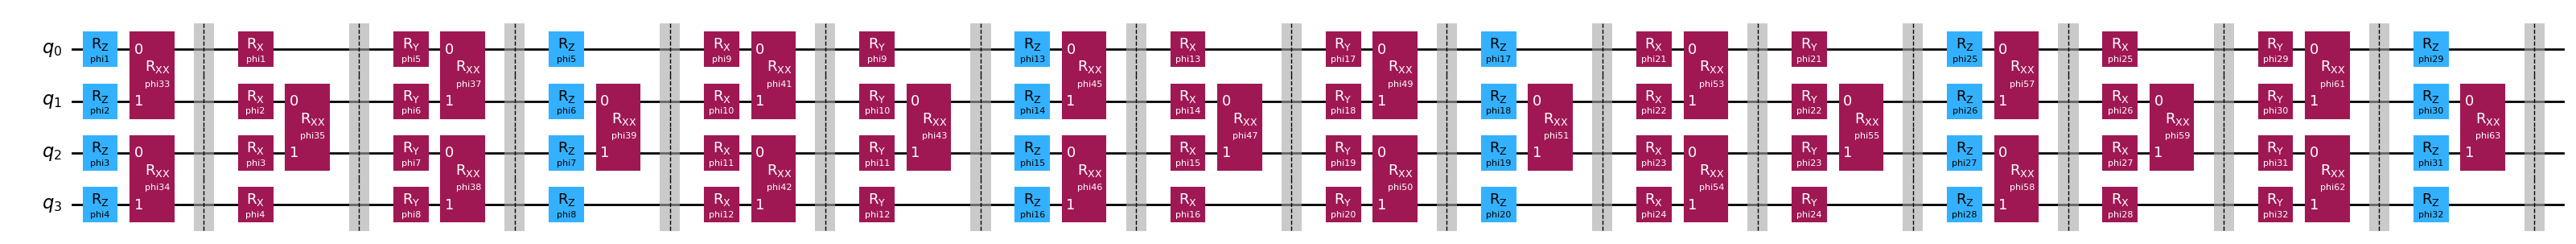

In [29]:
depth = 8
# num_nodes = graph.number_of_nodes()
ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits)
ansatz.draw('mpl',fold=-1)

In [30]:
pce = PauliCorrelationOptimizer(estimator=estimator, 
                                pauli_encoder=pauli_encoder,
                                depth=depth,
                                qp = problem_max_cut,
                                graph=graph,
                                num_qubits=num_qubits,
                                k=k,
                                max_cut_graph=max_cut_graph,
                                method='exact', 
                                loss_method='maxcut',
                                multi_op=False)  # method can be 'exact' or 'quantum' and loss can 
                                                # be qubo or maxcut


In [31]:
maxiter = 30
from qiskit_algorithms.optimizers import COBYLA,SLSQP,POWELL
optimizer = SLSQP(maxiter=maxiter)
params = np.random.rand(ansatz.num_parameters)
result=pce.optimize(optimizer,params)


Single Optimization


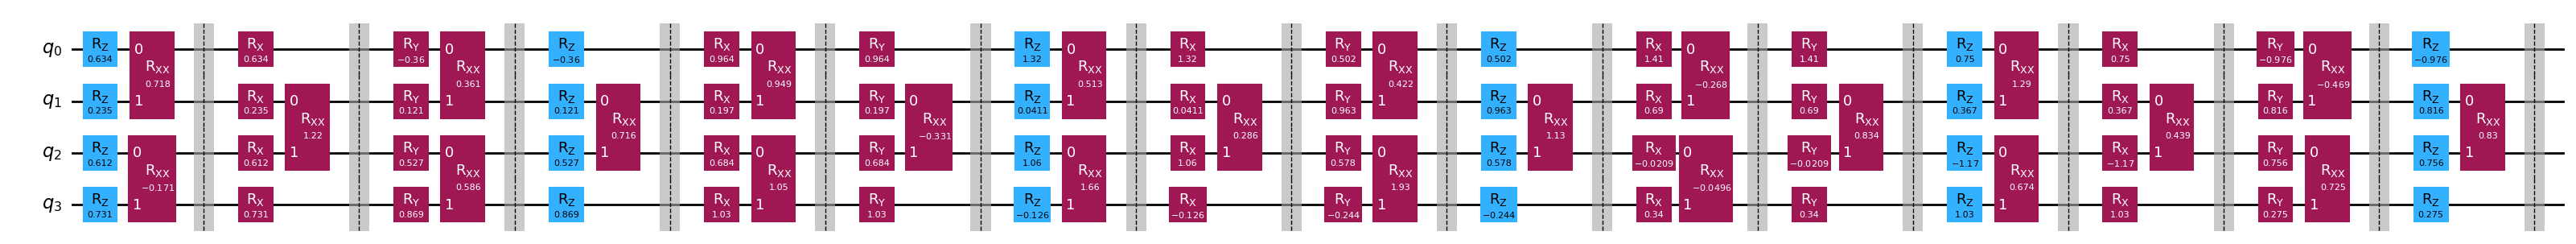

In [32]:
final_ansatz = pauli_encoder.BrickWork(depth= depth, num_qubits=num_qubits).assign_parameters(result)
final_ansatz.draw('mpl',fold=-1)

In [33]:
psi_final = Statevector(final_ansatz)

In [34]:
# Example usage:
# Assuming you have instantiated `psi_final`, `pauli_strings`, and `weight_matrix`
max_cut_utility = MaxCutUtility(max_cut_graph)
initial_score, max_cut_solution_pce = max_cut_utility.evaluate_initial_score(psi_final, pauli_strings)
print(f"Initial score: {initial_score}")
print(f"Max cut solution: {max_cut_solution_pce}")

Initial score: 722.0
Max cut solution: [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]


In [35]:
# convert to QUBO cost
qubo_solution_string = max_cut_utility.max_cut_to_qubo_solution(max_cut_solution_pce)
# get the qubo cost from the string
qubo_cost = qubo.objective.evaluate(qubo_solution_string)
print(f"QUBO cost: {qubo_cost}")
print(f"Qubo Solution Bitstring: {qubo_solution_string}")

QUBO cost: -3.0
Qubo Solution Bitstring: [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]


In [36]:

result_initial = converter.interpret(qubo_solution_string)
initial_cost = qp.objective.evaluate(result_initial)
# check feasibility
inital_feasible = qp.get_feasibility_info(result_initial)[0]

print("Initial Knapsack score             :", initial_cost )
print("Initial Knapsack solution          :", result_initial)
print("Initial Knapsack solution feasible :", inital_feasible)

Initial Knapsack score             : 3.0
Initial Knapsack solution          : [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
Initial Knapsack solution feasible : True


In [37]:
optimized_bitstring, final_cost = max_cut_utility.bit_swap_search(qubo, bitstring=qubo_solution_string)
print("Optimized bitstring:", optimized_bitstring)
print("Final cost:", final_cost)

Starting cost: -3.0
Bit flip: Improved solution by flipping bit 0: Cost = -4.0
Bit flip: Improved solution by flipping bit 1: Cost = -5.0
Bit flip: Improved solution by flipping bit 3: Cost = -6.0
Bit flip: Improved solution by flipping bit 10: Cost = -7.0
Bit flip: Improved solution by flipping bit 14: Cost = -8.0
Final best cost: -8.0
Optimized bitstring: [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1]
Final cost: -8.0
